In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import transformers
import torch
import os
import nltk
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from jinja2 import Template
import pickle
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import random

from transformers.generation.logits_process import LogitsProcessorList
logits_processor = LogitsProcessorList()

import sys
sys.path.append('/scratch/users/bozyurt20/hpc_run/utilities')
sys.path.append("/scratch/users/bozyurt20/hpc_run/blobs/")
sys.path.append("/scratch/users/bozyurt20/hpc_run/Inference/")
from util_research import *
from text_to_inject import chapter2_part1, chapter2_part2, chapter2_part2_part1, chapter2_part2_part2

max_len = 512
num_layers = 24
d_model = 4096

tokenizer = AutoTokenizer.from_pretrained("bigscience/T0pp", truncation_side="right", add_prefix_space=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#prng = np.random.RandomState(1)

babi_dataset_task1 = load_dataset('babi_qa', type='en-10k', task_no='qa1')

text_to_inject = remove_new_lines(chapter2_part1 + " " + chapter2_part2)
text_to_inject_sentences = text_to_inject.split(".")

class BabiDataPoint():
    def __init__(self, story, question, answer, knowledge_point):
        self.story = story
        self.question = question
        self.answer = answer
        self.knowledge_point = knowledge_point
    def add_story_encodings(self, encoding):
        self.story_encoding = encoding     
    def add_story_question_encodings(self, encoding):
        self.story_question_encoding = encoding
        
class TextInjectionDataPoint():
    def __init__(self, story, question, answer, prompt, token_distance):
        self.story = story
        self.question = question
        self.answer = answer
        self.prompt = prompt
        self.token_distance = token_distance

class TextInjectionBabiResultObject():
    def __init__(self, story, question, answer, prompt, token_distance, answer_predicted):
        self.story = story
        self.question = question
        self.answer = answer
        self.prompt = prompt
        self.token_distance = token_distance
        self.answer_predicted = answer_predicted

Using custom data configuration en-10k-qa1-task_no=qa1,type=en-10k
Found cached dataset babi_qa (/kuacc/users/bozyurt20/.cache/huggingface/datasets/babi_qa/en-10k-qa1-task_no=qa1,type=en-10k/1.2.0/a3c1ff28a1e13b872a34a5aae4a0d6715f4ff95cbc823c7d2c04f278e912dfab)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
len(text_to_inject_sentences)

24

In [46]:
model = AutoModelForSeq2SeqLM.from_pretrained("bigscience/T0pp", device_map='balanced', load_in_8bit=True)
#model.eval()

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /kuacc/users/bozyurt20/.conda/envs/hf/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110_nocublaslt.so...


/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)


In [29]:


num_ex = len(babi_dataset_task1["train"])
all_data_points = []
uniqueness = []


for i in range(num_ex):
    
    story_text = babi_dataset_task1["train"][i]["story"]["text"]
    types = babi_dataset_task1["train"][i]["story"]["type"]
    
    story = ""
    for j, sent in enumerate(story_text):
        
        if types[j] == 0:
            story += sent + " "
        elif types[j] == 1:
            
            question = sent
            answer = babi_dataset_task1["train"][i]["story"]["answer"][j]
            
            supporting_id = int(babi_dataset_task1["train"][i]["story"]["supporting_ids"][j][0])
            knowledge_point = story.rfind(story_text[supporting_id-1]) + len(story_text[supporting_id-1])
            
            data_point = BabiDataPoint(story[:-1], question, answer, knowledge_point)
            
            if data_point.story + data_point.question not in uniqueness:
                uniqueness.append(data_point.story + data_point.question)
                all_data_points.append(data_point)

                
num_ex = len(babi_dataset_task1["test"])

for i in range(num_ex):
    story_text = babi_dataset_task1["test"][i]["story"]["text"]
    types = babi_dataset_task1["test"][i]["story"]["type"]
    
    story = ""
    for j, sent in enumerate(story_text):
        if types[j] == 0:
            story += sent + " "
        elif types[j] == 1:
            question = sent
            answer = babi_dataset_task1["test"][i]["story"]["answer"][j]
            
            supporting_id = int(babi_dataset_task1["test"][i]["story"]["supporting_ids"][j][0])
            knowledge_point = story.rfind(story_text[supporting_id-1]) + len(story_text[supporting_id-1])
            
            data_point = BabiDataPoint(story[:-1], question, answer, knowledge_point)
            
            if data_point.story + data_point.question not in uniqueness:
                uniqueness.append(data_point.story + data_point.question)
                all_data_points.append(data_point)
            

"""with open("my_dataset.txt", "wb") as f:
    pickle.dump(all_data_points, f)"""

'with open("my_dataset.txt", "wb") as f:\n    pickle.dump(all_data_points, f)'

In [42]:
a = 9790
print(all_data_points[a].story)
print(all_data_points[a].question)
print(all_data_points[a].answer)
print(all_data_points[a].knowledge_point)

John went to the office. John journeyed to the garden. Daniel moved to the kitchen. John journeyed to the hallway. Daniel went to the office. Daniel went back to the garden.
Where is John?
hallway
114


In [82]:
smaller_dataset = random.choices(all_data_points, k=25)

In [83]:
       
text_injection_data_points = []

for num_sentence in range(len(text_to_inject_sentences)):
    for a, data_point in enumerate(smaller_dataset):
        print(a, end=" ")
        story = data_point.story
        question = data_point.question
        answer = data_point.answer
        knowledge_point = data_point.knowledge_point
        
        prompt = story + " " + ".".join(text_to_inject_sentences[:num_sentence+1]) + ". " + question
        
        
        token_distance = len(tokenizer.encode(prompt[knowledge_point:]))
        
        
        text_injection_data_points.append(TextInjectionDataPoint(story, question, answer, prompt, token_distance))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11

In [11]:
a = 30
print(text_injection_data_points[a].story)
print(text_injection_data_points[a].question)
print(text_injection_data_points[a].prompt)
print(text_injection_data_points[a].answer)
print(text_injection_data_points[a].token_distance)

John moved to the bedroom. Mary moved to the hallway.
Where is Mary?
John moved to the bedroom. Mary moved to the hallway. Mr Shepherd, a civil, cautious lawyer, who, whatever might be his hold or his views on Sir Walter, would rather have the disagreeable prompted by anybody else, excused himself from offering the slightest hint, and only begged leave to recommend an implicit reference to the excellent judgement of Lady Russell, from whose known good sense he fully expected to have just such resolute measures advised as he meant to see finally adopted. Where is Mary?
hallway
107


In [84]:
len(text_injection_data_points)

600

In [29]:
lengths = []
for dp in text_injection_data_points:
    prompt = dp.prompt
    lengths.append(len(tokenizer.encode(prompt)))

KeyboardInterrupt: 

In [ ]:
sum(lengths)(len(lengths))

In [26]:
with open("text-injection_babi_dataset.txt", "wb") as f:
    pickle.dump(text_injection_data_points, f)

In [61]:
print(len(tokenizer.encode("""Sandra travelled to the bathroom. Mary went back to the office. Sandra went to the bedroom. Mr Shepherd, a civil, cautious lawyer, who, whatever might be his hold or his views on Sir Walter, would rather have the disagreeable prompted by anybody else, excused himself from offering the slightest hint, and only begged leave to recommend an implicit reference to the excellent judgement of Lady Russell, from whose known good sense he fully expected to have just such resolute measures advised as he meant to see finally adopted.
Lady Russell was most anxiously zealous on the subject, and gave it much serious consideration.  She was a woman rather of sound than of quick abilities, whose difficulties in coming to any decision in this instance were great, from the opposition of two leading principles. She was of strict integrity herself, with a delicate sense of honour; but she was as desirous of saving Sir Walter's feelings, as solicitous for the credit of the family, as aristocratic in her ideas of what was due to them, as anybody of sense and honesty could well be.  She was a benevolent, charitable, good woman, and capable of strong attachments, most correct in her conduct, strict in her notions of decorum, and with manners that were held a standard of good-breeding.  She had a cultivated mind, and was, generally speaking, rational and consistent; but she had prejudices on the side of ancestry; she had a value for rank and consequence, which blinded her a little to the faults of those who possessed them.  Herself the widow of only a knight, she gave the dignity of a baronet all its due; and Sir Walter, independent of his claims as an old acquaintance, an attentive neighbour, an obliging landlord, the husband of her very dear friend, the father of Anne and her sisters, was, as being Sir Walter, in her apprehension, entitled to a great deal of compassion and consideration under his present difficulties.
They must retrench; that did not admit of a doubt.  But she was very anxious to have it done with the least possible pain to him and Elizabeth. She drew up plans of economy, she made exact calculations, and she did what nobody else thought of doing:  she consulted Anne, who never seemed considered by the others as having any interest in the question. She consulted, and in a degree was influenced by her in marking out the scheme of retrenchment which was at last submitted to Sir Walter. Where is John?""")))

563


In [86]:
answer_objects = []

for data_point in text_injection_data_points:
    story = data_point.story
    question = data_point.question
    answer = data_point.answer
    prompt = data_point.prompt
    token_distance = data_point.token_distance
    
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(input_ids, max_new_tokens=10)
    answer_predicted = tokenizer.decode(out[0], skip_special_tokens=True)
    
    answer_objects.append(TextInjectionBabiResultObject(story, question, answer, prompt, token_distance, answer_predicted))
  

new code working-utils
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
new code working-utils
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
new code working-utils
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
new code working-utils
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
llama generation happening.
new code working-modeling_t5
new code working-utils
new code working-modeling_t5

In [5]:
with open("/kuacc/users/bozyurt20/hpc_run/my_dataset.txt", "rb") as f:
    answer_objects = pickle.load(f)

In [7]:
len(answer_objects)

2400

In [6]:
loc_mention_graph = []
predictions = []
for obj in answer_objects:
    prompt = obj.prompt
    answer = obj.answer
    answer_predicted = obj.answer_predicted
    token_distance = obj.token_distance
    if answer in answer_predicted:
        predictions.append(1)
        loc_mention_graph.append((token_distance, 1))
    else:
        predictions.append(0)
        loc_mention_graph.append((token_distance, 0))
acc = sum(predictions)/len(predictions)
print("Accuracy for Question Type",  acc)

Accuracy for Question Type 0.5104166666666666


In [19]:
for tupl in loc_mention_graph:
    if tupl[0]>1060:
        print("YEs")

In [22]:
grap = defaultdict(list)

for tupl in loc_mention_graph:
    for i in range(11):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
           
for i in range(10):
    if len(grap[i]) != 0 and len(grap[i]) > 0:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

([<matplotlib.axis.XTick at 0x2b10a5f8e1c0>,
 [Text(0, 0, '0-350'),
  Text(1, 0, '350-700'),
  Text(2, 0, '700-1050'),
  Text(3, 0, ''),
  Text(4, 0, '1400-1750'),
  Text(5, 0, ''),
  Text(6, 0, '2100-2450'),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, '3150-3500')])

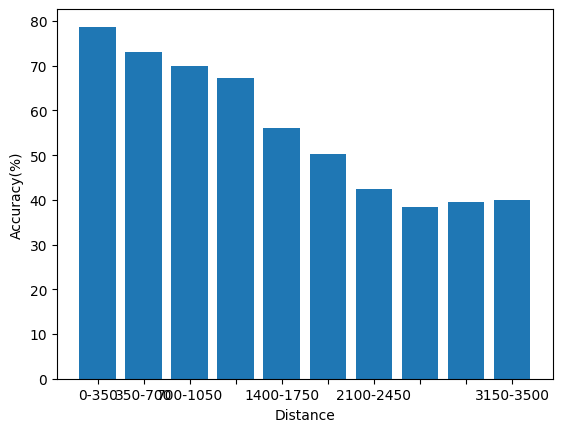

In [9]:
plt.bar(*zip(*grap_tuples))
plt.xlabel("Distance")
plt.ylabel("Accuracy(%)")
plt.xticks(np.arange(10), ['0-350', '350-700', '700-1050', "", "1400-1750","", "2100-2450", "", "", "3150-3500"])

In [27]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(11):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(11):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 0:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

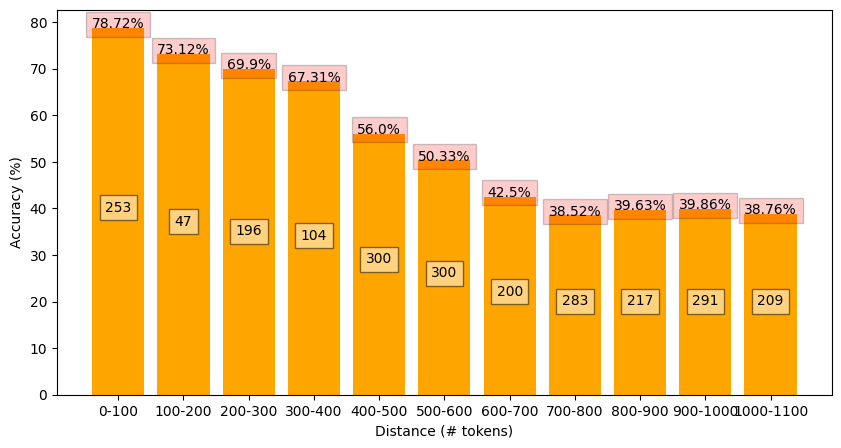

In [30]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2 + 0.25, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(11), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000", "1000-1100"])
plt.savefig('gpt2xl_fuzzy_2.png')